# APA Calling

## Aim
The purpose of this notebook is to call APA-based information (PDUI) based on [DAPARS2 method](https://github.com/3UTR/DaPars2).

## Methods

> ../../../images/apa_calling.png (45.2 KiB):

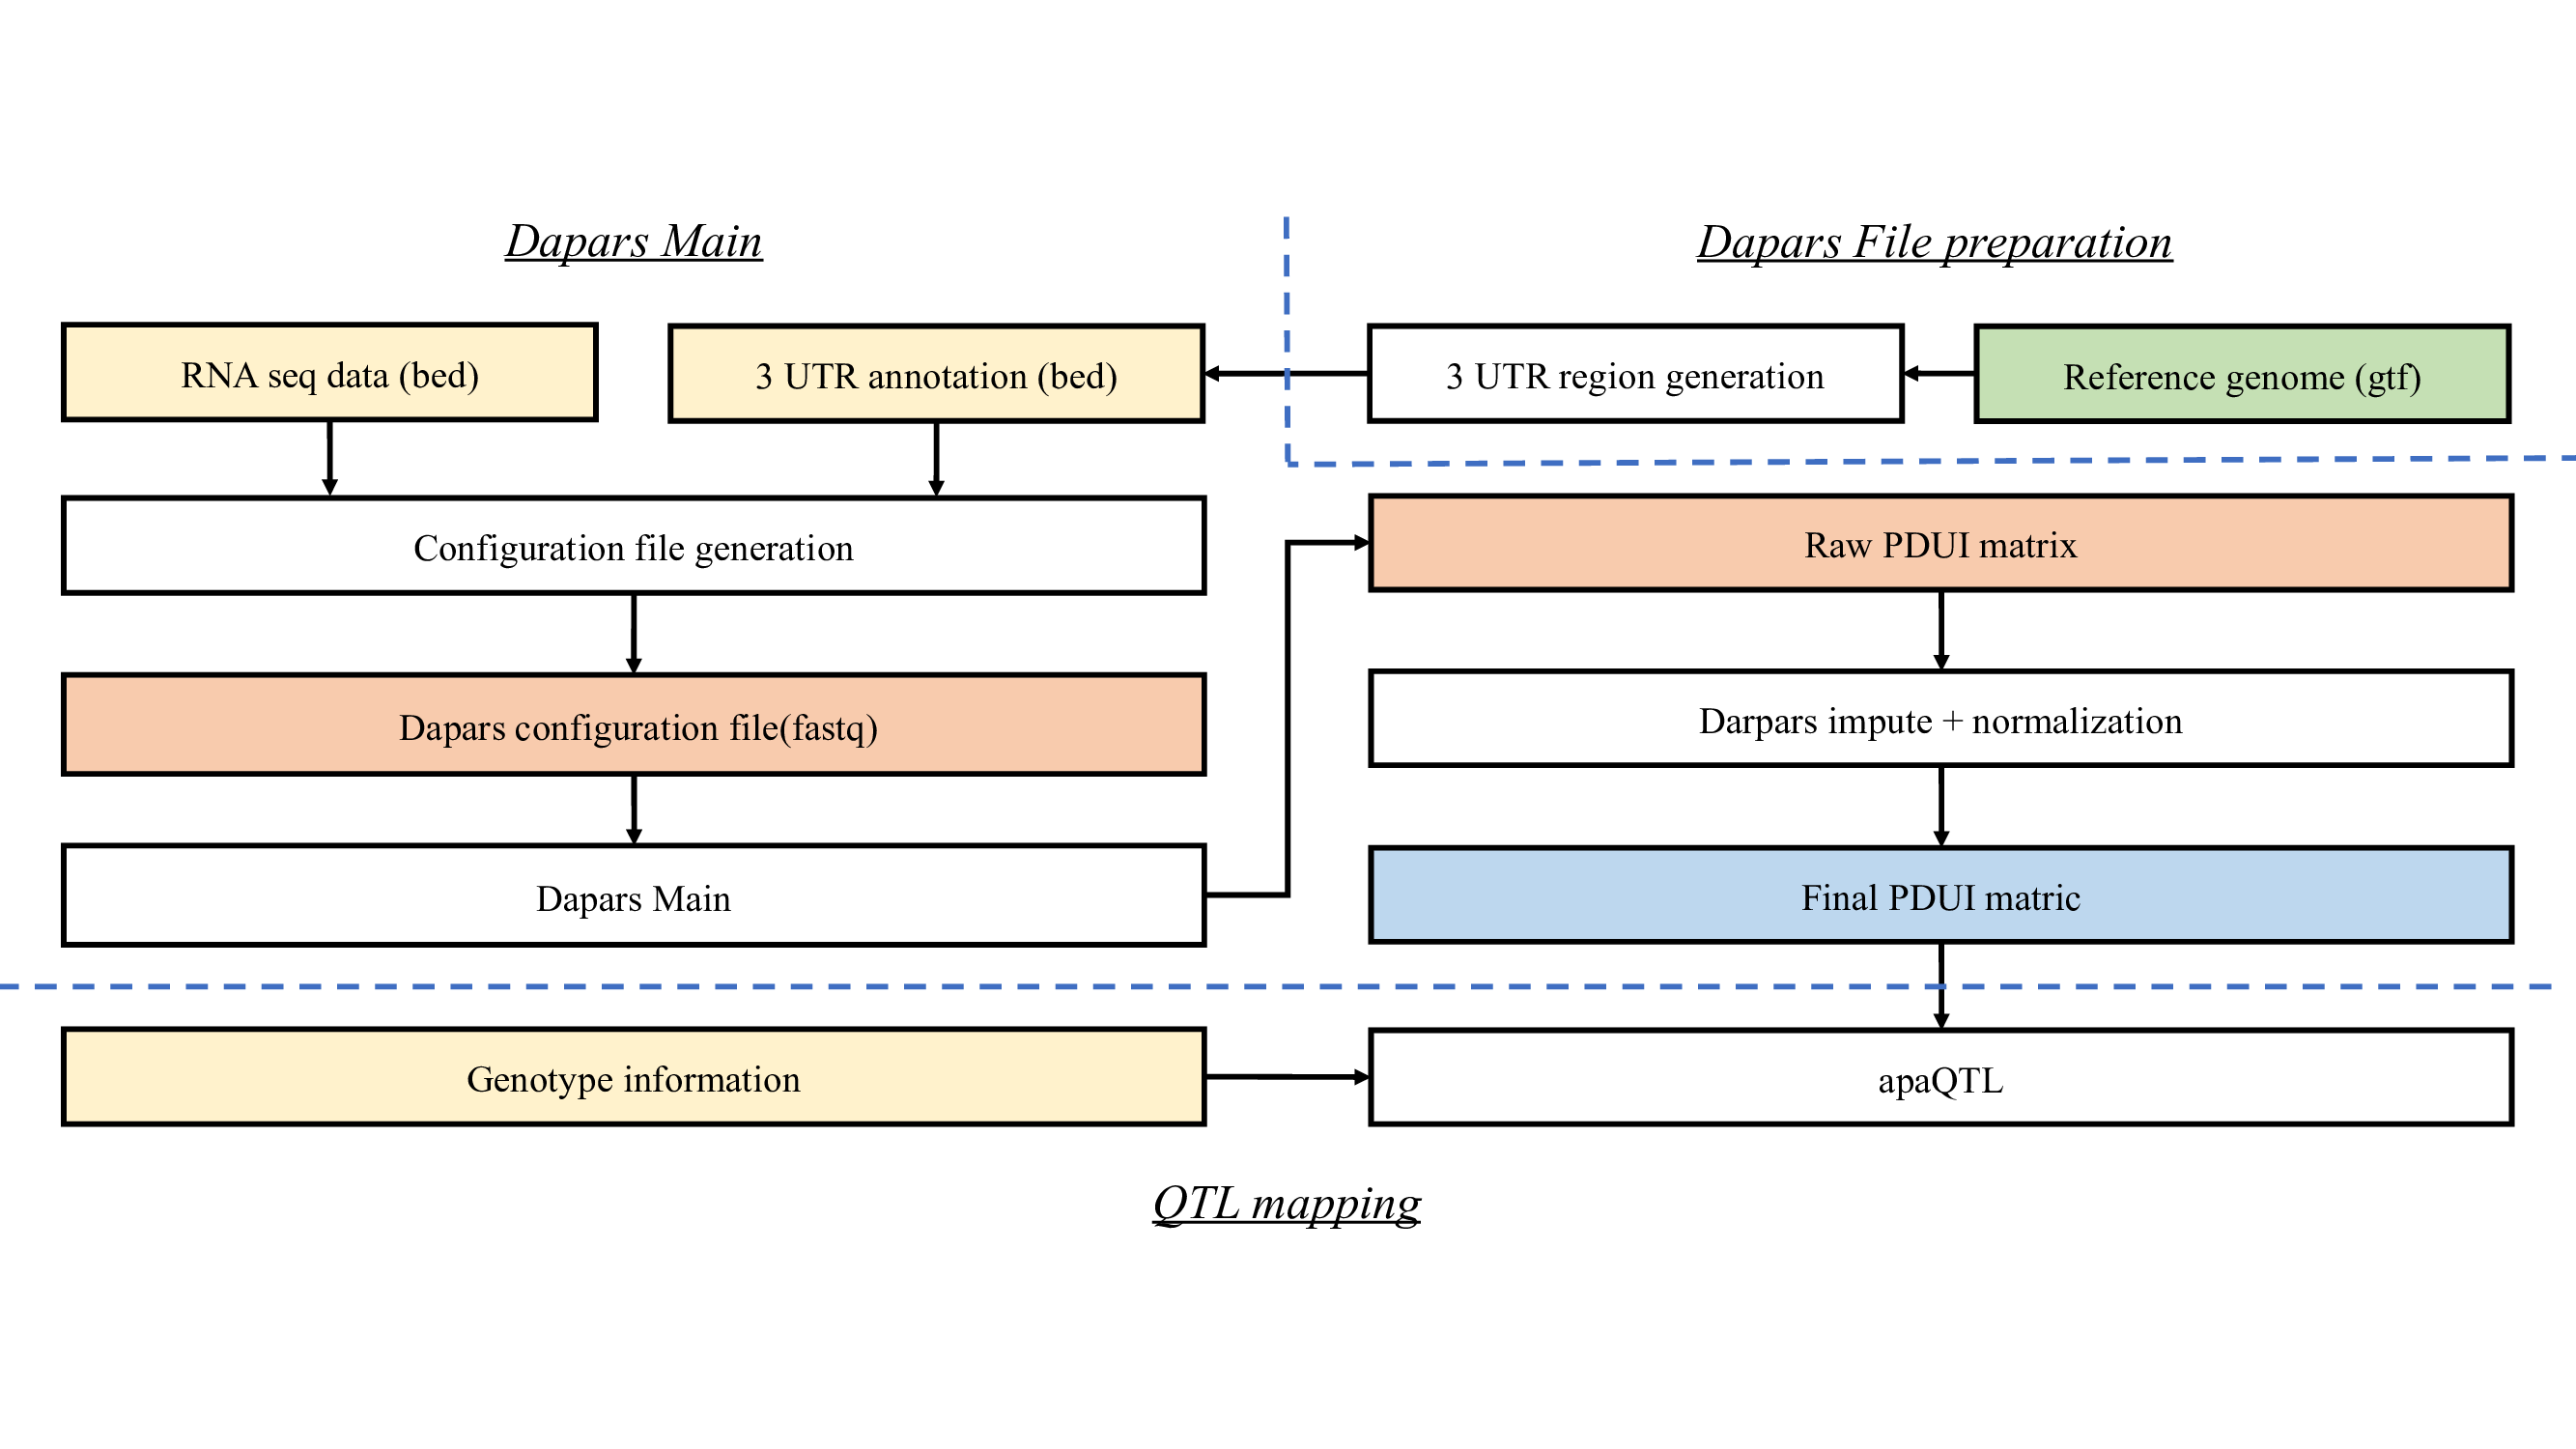

In [3]:
%preview ../../../images/apa_calling.png

### 3'UTR Reference

* _gtf2bed12.py_ : Covert gtf to bed format (Source from in-house codes from Li Lab: https://github.com/Xu-Dong/Exon_Intron_Extractor/blob/main/scripts/gtf2bed12.py)  

* _DaPars_Extract_Anno.py_ : extract the 3UTR regions in bed formats from the whole genome bed (Source from Dapars 2: https://github.com/3UTR/DaPars2/blob/master/src/DaPars_Extract_Anno.py)

### Call WIG data from transcriptome BAM files

Using bedtools or rsem-bam2wig, for RSEM based alignment

### Config files Generation
* _Python 3_ loops to read line by line the sum of reads coverage of all chromosome.

### Dapars2 Main Function

* _Dapars2_Multi_Sample.py_: use the least sqaures methods to calculate the usage of long isoforms (https://github.com/3UTR/DaPars2/blob/master/src/Dapars2_Multi_Sample.py)  
    
    Note: this part of code have been modified from source to deal with some formatting discrepancy in wig file

### Impute missing values in Dapars result

KNN using `VIM` R package.

## Input

- A list of transcriptome level BAM files, eg generated by RSEM
- The 3'UTR annotation reference file

If you do not have 3'UTR annotation file, please generate it first. Input to this step is the transcriptome level gene feature file in `GTF` format that [we previously prepared](../../data_preprocessing/reference_data.html).

## Output

*  Dapars config files
*  PUDI (Raw) information saved in txt
*  PDUI (Imputed) information saved in txt. This is recommended for further analysis. 

## Minimal working example

To generate 3'UTR reference data,

In [ ]:
sos run apa_calling.ipynb UTR_reference \
    --cwd output/apa \
    --hg-gtf reference_data/Homo_sapiens.GRCh38.103.chr.reformatted.ERCC.gtf \
    --container container/dapars2.sif

## Command interface

In [4]:
sos run apa_calling.ipynb -h

usage: sos run apa_calling.ipynb [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  UTR_reference
  APAconfig
  APAmain
  APAimpute

Global Workflow Options:
  --walltime 36h
  --mem 100G
  --ncore 22 (as int)
  --cwd VAL (as path, required)
                        the output directory for generated files
  --thread 8 (as int)
                        path to GTF file
  --job-size 22 (as int)
  --container ''

Sections
  UTR_reference:        Generate the 3UTR region according to the gtf file
    Workflow Options:
      --hg-gtf VAL (as path, required)
                        gtf file
  APAconfig:            Calculcate total depth and configuration file
    Workflow Options:
      --bfile

## Workflow implementation

In [1]:
[global]
parameter: walltime = '36h'
parameter: mem = '100G'
parameter: ncore = 22
# the output directory for generated files
parameter: cwd = path
# path to GTF file 
parameter: thread = 8
parameter: job_size = 22
parameter: container = ''

### Step 0: Generate 3UTR regions based on GTF 

The 3UTR regions (saved in bed format) could be use __repeatly__ for different samples. It only served as the reference region. You may not need to run it if given generated hg19/hg38 3UTR regions.

In [2]:
# Generate the 3UTR region according to the gtf file
[UTR_reference]
# gtf file
parameter: hg_gtf = path
input: hg_gtf
output: f'{cwd}/{_input:bn}.bed', 
        f'{cwd}/{_input:bn}.transcript_to_geneName.txt',
        f'{cwd}/{_input:bn}_3UTR.bed'
bash: expand = '${ }', container = container
    gtf2bed12.py --gtf ${_input} --out ${cwd}
    mv ${cwd}/gene_annotation.bed ${_output[0]}
    mv ${cwd}/transcript_to_geneName.txt ${_output[1]}
    DaPars_Extract_Anno.py -b ${_output[0]} -s ${_output[1]} -o ${_output[2]}

### Step 1: Generate WIG calls from BAM files

Generating WIG from BAM data via `bedtools` is recommended by Dapars authors. However, our transcriptome level calls are made using RSEM, which in fact contains a program called `rsem-bam2wig` with this one additional feature:

```
–no-fractional-weight : If this is set, RSEM will not look for “ZW” tag and each alignment appeared in the BAM file has weight 1. Set this if your BAM file is not generated by RSEM. Please note that this option must be at the end of the command line
```

Here we stick to `bedtools` because of its popularity and most generic BAM files may not have the `ZW` tag anyways.

In [ ]:
[wigconverting]
parameter: n = 9
n  = [x for x in range(n)]
input: for_each = 'n'
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = ncore
python: expand = True
    import glob
    import os
    import subprocess
    path = "/mnt/mfs/ctcn/datasets/rosmap/rnaseq/dlpfcTissue/batch{_n}/STAR_aligned"
    name = glob.glob(path + "/**/*Aligned.sortedByCoord.out.bam", recursive = True)
    wigpath = "/home/ls3751/project/ls3751/wig/batch{_n}/"
    if not os.path.exists(wigpath):
        os.makedirs(os.path.dirname(wigpath))
    for i in name:
        str1 = ""
        id = i.split("/")[-2]
        out = wigpath + id + ".wig"
        # new_cmd = "echo " + i + " > " + out
        new_cmd = "bedtools genomecov -ibam " + i + " -bga -split -trackline" + " > " + out
        os.system(new_cmd)

### Step 2: Generating config files and calculating sample depth

#### Notes on input file format

For the input file, it has the following format. Additional notes are:
* The first line is the information of file. If you do not have them, please add any content on first line
* The file must end with ".wig". It will not cause any problem if you directly change from ".bedgraph"
* If your input wig file did not have the characters __"chr"__ in the first column, please set `no_chr_prefix = T`

In [7]:
head -n 10 /mnt/mfs/statgen/ls3751/MWE_dapars2/sample1.wig

track type=bedGraph
1	0	10099	0
1	10099	10113	1
1	10113	10146	0
1	10146	10157	2
1	10157	10230	0
1	10230	10241	2
1	10241	10279	0
1	10279	10301	1
1	10301	10329	0


In [17]:
# Calculcate total depth and configuration file
[APAconfig]
parameter: bfile = path
parameter: annotation = path
parameter: job_size = 1
# Default parameters for Dapars2:
parameter: least_pass_coverage_percentage = 0.3
parameter: coverage_threshold = 10
parameter: no_chr_prefix = "F"
output: [f'{cwd}/sample_mapping_files.txt',f'{cwd}/sample_configuration_file.txt']
task: trunk_workers = 1, trunk_size = 1, walltime = walltime, mem = mem, cores = ncore
python3: expand = "${ }", container = container
    import re
    import os
    target_all_sample = os.listdir("${bfile}")
    target_all_sample = list(filter(lambda v: re.match('.*wig$', v), target_all_sample))
    target_all_sample = ["${bfile}" + "/" + w for w in target_all_sample]
    #print(target_all_sample)
    print("INFO: Total",len(target_all_sample),"samples found in provided dirctory!")
    # Total depth file:
    chr = []
    for i in range(22):
        chr.append(str(i+1))
    chr = chr + ["X","Y"]
    if "${no_chr_prefix}" == "F":
        chr = ['chr' + str(a) for a in chr]
    mapping_file = open("${_output[0]}", "w")
    for current_sample in target_all_sample:
        current_sample_total_depth = 0
        # skip the default type = bedgraph line
        for line in open(current_sample,'r'):
            if line[0] != '#' and line[0] != 't':
                fields = line.strip('\n').split('\t')
                curr_chr = fields[0]
                region_start = int(fields[1])
                region_end = int(fields[2])
                current_sample_total_depth += (curr_chr in chr) * int(float(fields[-1])) * (region_end - region_start)
        field_out = [current_sample, str(current_sample_total_depth)]
        mapping_file.writelines('\t'.join(field_out) + '\n')

        print("Coverage of sample ", current_sample, ": ", current_sample_total_depth)
    mapping_file.close()

    # Configuration file:

    config_file = open(${_output[1]:r},"w")
    config_file.writelines(f"Annotated_3UTR=${annotation}\n")
    config_file.writelines( "Aligned_Wig_files=%s\n" % ",".join(target_all_sample))
    config_file.writelines(f"Output_directory=../../../../../MWE_dapars2/Output/Wigfiles\n")
    config_file.writelines(f"Output_result_file=Dapars_result\n")
    config_file.writelines(f"Least_pass_coverage_percentage=${least_pass_coverage_percentage}\n")
    config_file.writelines( "Coverage_threshold=${coverage_threshold}\n")
    config_file.writelines( "Num_Threads=${thread}\n")
    config_file.writelines(f"sequencing_depth_file=${_output[0]}") 
    config_file.close()    

### Step 3: Run Dapars2 main to calculate PDUIs
Default input of `Dapars2_Multi_Sample.py` did not consider the situation that first column did not contain "chr" (shown in _Step 2_). We add a new argument no_chr_prefix (default is FALSE)

In [12]:
# Call Dapars2 multi_chromosome
[APAmain]
parameter: chr_prefix = False
parameter: chrlist = list
input: for_each = 'chrlist'
output: [f'{cwd}/Wigfiles_{x}/Dapars_result_result_temp.{x}.txt' for x in chrlist], group_by = 1
task: trunk_workers = 1, trunk_size = job_size, walltime = walltime, mem = mem, cores = ncore
bash: expand = True, container = container
    Dapars2_Multi_Sample.py {cwd}/sample_configuration_file.txt {_chrlist} {"F" if chr_prefix else "T"}

### Step 4: Inpute missing values 
This step impute the missing value in PDUI matrix and return the Imputed one

In [10]:
# Dapars result Imputation 
[APAimpute]
# Input path
# parameter: dapars_raw = 
parameter: chrlist = list
# Default k neighbours. Set k = 0 will train the k in a data-driven manner
parameter: knn = 8
input: [f'{cwd}/Wigfiles_{x}/Dapars_result_result_temp.{x}.txt' for x in chrlist], group_by = 1
output: [f'{cwd}/Dapars_result_imputed_{x}.txt' for x in chrlist], group_by = 1
R: expand= "${ }", container = container

.libPaths( c('/usr/local/lib/R/site-library' , '/usr/lib/R/site-library', '/usr/lib/R/library', .libPaths()))
suppressPackageStartupMessages(require(dplyr))
suppressPackageStartupMessages(require(tidyr))
suppressPackageStartupMessages(require(doParallel))
suppressPackageStartupMessages(require(VIM))
suppressPackageStartupMessages(require(preprocessCore))
  
  
# KNN impute

# Decide the optimal n if possible. Set the k to 2:#sample 
# and train a best k. The idea is that, randomly remove 
# 20% numbers in the full value subset 5 times, calculate 
# MSE of imputed value by VIM and true value to decide which 
# k is the optimal one. (an analog from 5 fold CV)
  
  
knn_train_sample <- function(input_df, k_nb){
      # Sample data and remove entries
      # We must keep 1 full col for impute
      dim_df <- dim(input_df)
      sample_size <-  round(dim_df[1] * dim_df[2] * 0.2, 0)
      row_index <- sample(1:nrow(input_df), sample_size)
      col_index <- sample(1:ncol(input_df), sample_size, replace = T)
      val_list <- c()
      for(i in 1:length(row_index)){
        val_list <- c(val_list, input_df[row_index[i], col_index[i]])
        input_df[row_index[i], col_index[i]] <- NA
      }

      # Impute value

      impute_data <- VIM::kNN(input_df, k = k_nb)
      impute_data <- impute_data[,1:ncol(input_df)]

      # Calculate the MSE:
      predict_list <- c()
      for(i in 1:length(row_index)){
        predict_list <- c(predict_list, impute_data[row_index[i], col_index[i]])
      }
      tss <- sum((predict_list - val_list)^2)
      return(tss)
}
  
 # Read the data
    input_dir <- ${_input:r}
  

    dapars_result <- 
      read.table(input_dir,
                 header = T) 
    
    dapars_names <- 
      dapars_result %>% 
      select(1:3)
  
    dapars_result <-
      dapars_result %>% 
      select(-1:-3) 
 
  if(${knn} == 0){
    

    dapars_train_data <- dapars_result %>% drop_na()

    # Train the model
    no_cores <- detectCores() - 1
    cl <- makeCluster(no_cores)
    registerDoParallel(cl)

    index <- seq(2, ncol(dapars_train_data), by = 1)  # Change by = x for precision, for large dataset, please make it bigger
    result_list <- c()
    for(i in 1:length(index)){
        print(paste0("Train k = ",index[i]))
        re <- foreach(j=1:5,.combine = c) %dopar% 
          knn_train_sample(dapars_train_data, index[i])
        result_list <- c(result_list, mean(re))
      }

    optimal_k <- index[which.min(result_list)]
    print(paste0("Optimal k selected is ", optimal_k))
    }else{
      optimal_k <- ${knn} 
      print(paste0("Use k = ", optimal_k, " for imputation"))
    }
      
    
  
    # Train the whole dataset:
    imputed_full_data <- VIM::kNN(dapars_result, k = optimal_k)
    imputed_full_data <- imputed_full_data[,1:ncol(dapars_result)]
  
    qnorm_full_data <- 
      preprocessCore::normalize.quantiles(as.matrix(imputed_full_data), 
                                          copy = F)
  
    final_data <- cbind(dapars_names, qnorm_full_data)
    write.table(final_data, file = ${_output:r}, quote = F)

## Analysis demo
### Step 0: 3UTR generation

In [18]:
sos run /mnt/mfs/statgen/ls3751/github/xqtl-pipeline/pipeline/molecular_phenotypes/calling/apa_calling.ipynb UTR_generation \
    --cwd /mnt/mfs/statgen/ls3751/MWE_dapars2/Output \
    --gtf /mnt/mfs/statgen/ls3751/MWE_dapars2/gencode.v19.annotation.gtf \
    --container /mnt/mfs/statgen/ls3751/container/dapars2.sif

INFO: Running UTR_generation_1: Generate the 3UTR region according to the gtf file
Done!
INFO: UTR_generation_1 is completed.
INFO: UTR_generation_1 output:   /mnt/mfs/statgen/ls3751/MWE_dapars2/Output/gene_annotation.bed /mnt/mfs/statgen/ls3751/MWE_dapars2/Output/transcript_to_geneName.txt
INFO: Running UTR_generation_2: 
Generating regions ...
Total extracted 3' UTR: 140563
Finished
INFO: UTR_generation_2 is completed.
INFO: UTR_generation_2 output:   /mnt/mfs/statgen/ls3751/MWE_dapars2/Output/gencode.v19.annotation_3UTR.bed
INFO: Workflow UTR_generation (ID=wf41b62313b6bb15a) is executed successfully with 2 completed steps.


In [19]:
tree /mnt/mfs/statgen/ls3751/MWE_dapars2/Output

/mnt/mfs/statgen/ls3751/MWE_dapars2/Output
├── gencode.v19.annotation_3UTR.bed
├── gene_annotation.bed
└── transcript_to_geneName.txt

0 directories, 3 files


### Step 1: Generating config files and calculating sample depth


In [18]:
sos run /mnt/mfs/statgen/ls3751/github/xqtl-pipeline/pipeline/molecular_phenotypes/calling/apa_calling.ipynb APAconfig \
    --cwd /mnt/mfs/statgen/ls3751/MWE_dapars2/Output \
    --bfile /mnt/mfs/statgen/ls3751/MWE_dapars2 \
    --annotation /mnt/mfs/statgen/ls3751/MWE_dapars2/Output/gencode.v19.annotation_3UTR.bed \
    --no_chr_prefix T \
    --container /mnt/mfs/statgen/ls3751/container/dapars2.sif

INFO: Running APAconfig: Calculcate total depth and configuration file
INFO: Total 4 samples found in provided dirctory!
Coverage of sample  /mnt/mfs/statgen/ls3751/MWE_dapars2/sample4.wig :  5943757290
Coverage of sample  /mnt/mfs/statgen/ls3751/MWE_dapars2/sample3.wig :  6060347021
Coverage of sample  /mnt/mfs/statgen/ls3751/MWE_dapars2/sample2.wig :  3617065465
Coverage of sample  /mnt/mfs/statgen/ls3751/MWE_dapars2/sample1.wig :  2573149742
INFO: APAconfig is completed.
INFO: APAconfig output:   /mnt/mfs/statgen/ls3751/MWE_dapars2/Output/sample_mapping_files.txt /mnt/mfs/statgen/ls3751/MWE_dapars2/Output/sample_configuration_file.txt
INFO: Workflow APAconfig (ID=wdc3865265bf562ea) is executed successfully with 1 completed step.


In [22]:
tree /mnt/mfs/statgen/ls3751/MWE_dapars2/Output

/mnt/mfs/statgen/ls3751/MWE_dapars2/Output
├── gencode.v19.annotation_3UTR.bed
├── gene_annotation.bed
├── sample_configuration_file.txt
├── sample_mapping_files.txt
└── transcript_to_geneName.txt

0 directories, 5 files


### Step 2: Dapars2 Main
Note: the example is a truncated version, which just have coverage in chr1,chr11 and chr12

In [2]:
sos run /mnt/mfs/statgen/ls3751/github/xqtl-pipeline/pipeline/molecular_phenotypes/calling/apa_calling.ipynb APAmain \
    --cwd /mnt/mfs/statgen/ls3751/MWE_dapars2/Output \
    --no_chr_prefix T \
    --chrlist chr1 \
    --container /mnt/mfs/statgen/ls3751/container/dapars2.sif

INFO: Running APAmain: Call Dapars2 multi_chromosome
[Sun Jan 30 04:15:34 2022] Start Analysis ...
All samples Joint Processing chr1 ...
[Sun Jan 30 04:15:34 2022] Loading Coverage ...
/mnt/mfs/statgen/ls3751/MWE_dapars2/sample4.wig
/mnt/mfs/statgen/ls3751/MWE_dapars2/sample3.wig
/mnt/mfs/statgen/ls3751/MWE_dapars2/sample2.wig
/mnt/mfs/statgen/ls3751/MWE_dapars2/sample1.wig
[5943757290 6060347021 3617065465 2573149742]
[Sun Jan 30 04:15:46 2022] Loading Coverage Finished ...
#assigned events:
1379
1379
1379
1379
1379
1378
1378
1378
[Sun Jan 30 04:15:51 2022] Finished!
INFO: APAmain is completed.
INFO: APAmain output:   /mnt/mfs/statgen/ls3751/MWE_dapars2/Output/Wigfiles_chr1/Dapars_result_result_temp.chr1.txt
INFO: Workflow APAmain (ID=w28477dad0713d81d) is executed successfully with 1 completed step.


In [3]:
tree /mnt/mfs/statgen/ls3751/MWE_dapars2/Output

/mnt/mfs/statgen/ls3751/MWE_dapars2/Output
├── gencode.v19.annotation_3UTR.bed
├── gene_annotation.bed
├── sample_configuration_file.txt
├── sample_mapping_files.txt
├── transcript_to_geneName.txt
└── Wigfiles_chr1
    ├── Dapars_result_result_temp.chr1.txt
    └── tmp
        ├── Each_processor_3UTR_Result_1.txt
        ├── Each_processor_3UTR_Result_2.txt
        ├── Each_processor_3UTR_Result_3.txt
        ├── Each_processor_3UTR_Result_4.txt
        ├── Each_processor_3UTR_Result_5.txt
        ├── Each_processor_3UTR_Result_6.txt
        ├── Each_processor_3UTR_Result_7.txt
        └── Each_processor_3UTR_Result_8.txt

2 directories, 14 files


### Step 3: Impute

In [11]:
sos run /mnt/mfs/statgen/ls3751/github/xqtl-pipeline/pipeline/molecular_phenotypes/calling/apa_calling.ipynb APAimpute \
    --cwd /mnt/mfs/statgen/ls3751/MWE_dapars2/Output \
    --chrlist chr1 \
    --container /mnt/mfs/statgen/ls3751/container/dapars2.sif

INFO: Running APAimpute: Dapars result Imputation
Warning message:
package ‘VIM’ was built under R version 4.0.5 
[1] "Use k = 5 for imputation"
Error in preprocessCore::normalize.quantiles(as.matrix(imputed_full_data),  : 
  ERROR; return code from pthread_create() is 22
In addition: Warning message:
In preprocessCore::normalize.quantiles(as.matrix(imputed_full_data),  :
  NAs introduced by coercion
Execution halted
ERROR: APAimpute (id=9d62c6b78d820375) returns an error.
ERROR: [APAimpute]: [0]: Executing script in Singularity returns an error (exitcode=1).
The script has been saved to /home/ls3751/.sos/a23a325a1ed7f8c9/singularity_run_19849.R. To reproduce the error please run:
singularity exec  /mnt/mfs/statgen/ls3751/container/dapars2.sif Rscript /home/ls3751/.sos/a23a325a1ed7f8c9/singularity_run_19849.R


: 1